In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive



In [22]:
drive.mount('/content/drive')

# Set dataset paths
train_dir = '/content/drive/My Drive/effecienttrain'
test_dir = '/content/drive/My Drive/augmented/FINAL'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,  # Less rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 660 images belonging to 2 classes.
Found 229 images belonging to 2 classes.


In [24]:
# Load Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build Model on Top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),  # Stronger regularization
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')
])

# Compile Model with Higher Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Increased LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,552,065 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cosine Decay Learning Rate
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=50, alpha=0.1
)

# Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Early Stopping (Stop if no improvement for 5 epochs)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=49,
    callbacks=[reduce_lr, early_stopping],  # Added Early Stopping
    verbose=1
)


Epoch 1/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.8562 - loss: 1.8129 - val_accuracy: 0.5721 - val_loss: 4.3800 - learning_rate: 0.0010
Epoch 2/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.8689 - loss: 1.4236 - val_accuracy: 0.4672 - val_loss: 8.2653 - learning_rate: 0.0010
Epoch 3/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.8807 - loss: 1.1233 - val_accuracy: 0.4760 - val_loss: 7.4241 - learning_rate: 0.0010
Epoch 4/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.8796 - loss: 0.9422 - val_accuracy: 0.6245 - val_loss: 4.6818 - learning_rate: 0.0010
Epoch 5/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.8900 - loss: 0.7820 - val_accuracy: 0.4978 - val_loss: 8.3382 - learning_rate: 0.0010
Epoch 6/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.8937 - loss: 0.6197 - val_accuracy: 0.5153 - val_loss: 6.2230 - learning_rate: 0.0010
Epoch 7/49
21/21 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.9041 - loss: 0.5388 - val_acc

In [27]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 939ms/step - accuracy: 0.7794 - loss: 2.1554
Test Accuracy: 0.8297
Test Loss: 1.6929


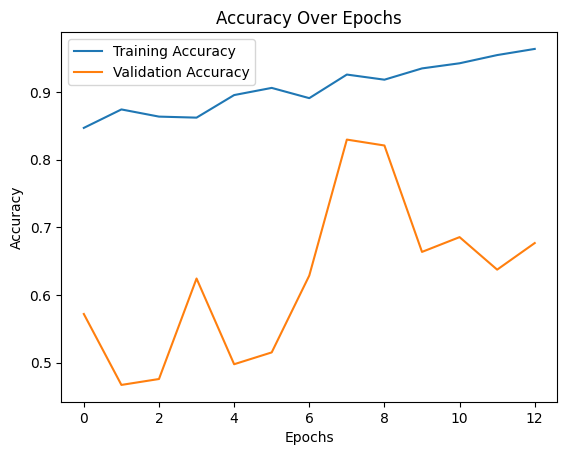

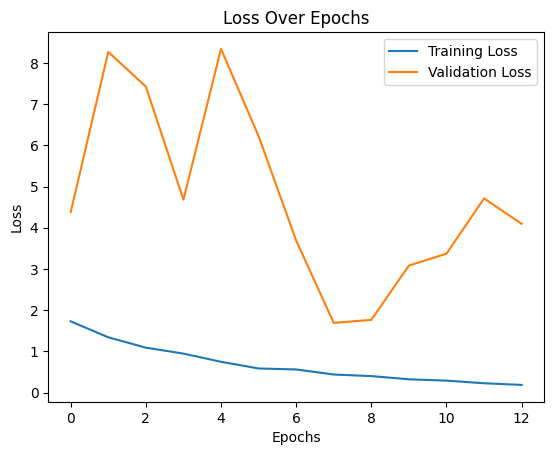

In [28]:
# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [29]:
model.save('/content/drive/My Drive/final_optimized_model.h5')
print("Model saved successfully!")


Model saved successfully!
